# openFE Atom Mappers

## Build test data:
Initially start with some example data

In [1]:
import openfe
from rdkit import Chem
from openff.toolkit.topology import Molecule
from openfe.setup import SmallMoleculeComponent

# some heterocycles 
naphthalene = Chem.MolFromSmiles('c12ccccc1cccc2')
benzoxazole = Chem.MolFromSmiles('n1c2ccccc2oc1')
indane = Chem.MolFromSmiles('c1ccc2c(c1)CCC2')
skatole = Chem.MolFromSmiles('CC1=CNC2=CC=CC=C12')
benzene = Chem.MolFromSmiles('c1ccccc1')
quinoline = Chem.MolFromSmiles('n1cccc2ccccc12')
toluene = Chem.MolFromSmiles('c1ccccc1C')
methylpyridine = Chem.MolFromSmiles('c1ccncc1C')
phenol = Chem.MolFromSmiles('c1ccccc1O')
catechol = Chem.MolFromSmiles('c1cccc(O)c1O')
nitrobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)[N+](=O)[O-]')
cyclohexane = Chem.MolFromSmiles('C1CCCCC1')


mols_rdkit = [benzene,
              phenol,
              toluene,
              naphthalene, 
              benzoxazole,
              indane,
              skatole,
              quinoline,
              methylpyridine,                
              catechol,
              nitrobenzene,
              cyclohexane
            ]

mols_rdkit = list(map(lambda x: Chem.AddHs(x), mols_rdkit))
[Chem.rdDistGeom.EmbedMolecule(mol) for mol in mols_rdkit]
mols_off = list(map(lambda x:Molecule.from_rdkit(x), mols_rdkit))
mols = list(map(lambda x:SmallMoleculeComponent.from_openff(x, x.name), mols_off))


/home/riesbenj/Programs/miniconda3/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/riesbenj/Programs/miniconda3/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/riesbenj/Programs/miniconda3/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/riesbenj/Programs/miniconda3/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


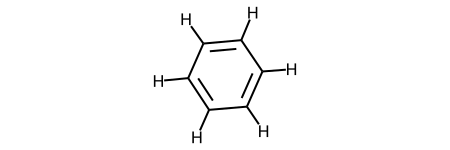

In [2]:
mols[0]._rdkit

In [3]:
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem

def align_molB_to_molA_sceletons(molA:SmallMoleculeComponent, 
                                 molB:SmallMoleculeComponent,
                                 verbose:bool = False,
                        ) -> SmallMoleculeComponent:
    mol1b = molA._rdkit
    mol2b = molB._rdkit
        
    p = rdFMCS.MCSParameters()
    p.AtomTyper = rdFMCS.AtomCompare.CompareAny

    
    res = rdFMCS.FindMCS([mol1b, mol2b],p)
    
    # convert match to mapping
    q = Chem.MolFromSmarts(res.smartsString)
    if(verbose): print(q)

    m1_idx = mol1b.GetSubstructMatch(q)
    m2_idx = mol2b.GetSubstructMatch(q)
    if(verbose): print(m1_idx, m2_idx)

    idx_mappings = list(zip(m2_idx,m1_idx))

    rms = AllChem.AlignMol(
        prbMol=mol2b, refMol=mol1b, atomMap=idx_mappings,
    )
    if(verbose): print(rms)

    molB._rdkit = mol2b
    return molB

mol1 = mols[0]
for mol2 in mols[1:]:
    mol2 = align_molB_to_molA_sceletons (mol1, mol2, verbose=False)


In [4]:
#Check alignment
import nglview as ng
s = ng.show_rdkit(mols[0]._rdkit)

for mol2 in mols[1:]:
    s.add_component(mol2._rdkit)
    s.display()
s

NGLWidget()

# Atom Mappers

In [5]:
molA = mols[0]
molB = mols[3]

## Lomap Mapper

CPU times: user 69.7 ms, sys: 396 µs, total: 70.1 ms
Wall time: 68.3 ms
Lomap-Score is 0.3296799539643607


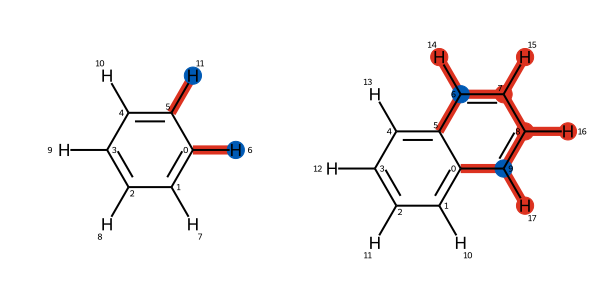

In [6]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
lomap_mapper = openfe.setup.LomapAtomMapper()

        
# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
%time lomap_mapping = next(lomap_mapper.suggest_mappings(molA, molB))

#perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(lomap_mapping)}")
#print(f"Perses-Score is {perses_scorer(lomap_mapping)}")

lomap_mapping

## Perses Mapper

CPU times: user 88.4 ms, sys: 3.29 ms, total: 91.7 ms
Wall time: 146 ms
Lomap-Score is 0.6321205588285577
Perses-Score is 0.6965517241379311


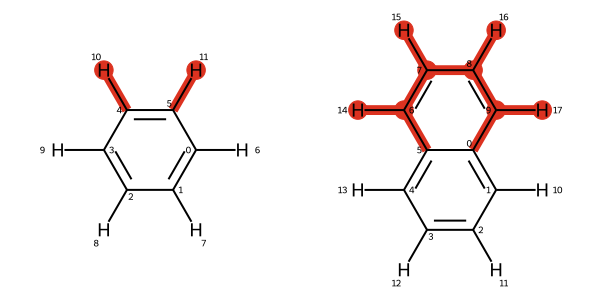

In [7]:
# Perses wraps the perses mapping object
perses_mapper = openfe.setup.atom_mapping.PersesAtomMapper()

# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
%time perses_mapping = next(perses_mapper.suggest_mappings(molA, molB))

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(perses_mapping)}")
print(f"Perses-Score is {perses_scorer(perses_mapping)}")

perses_mapping

## The Rdkit - Gowers Variant

CPU times: user 2.45 ms, sys: 191 µs, total: 2.64 ms
Wall time: 2.1 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.7655172413793104


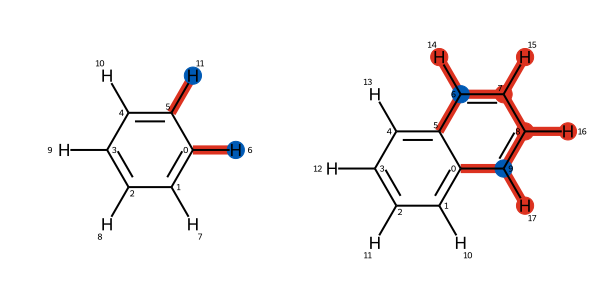

In [8]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
rdfmcs_mapper = openfe.setup.atom_mapping.RDFMCSMapper()

# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
%time rdfmcs_mapping = next(rdfmcs_mapper.suggest_mappings(molA, molB))

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(rdfmcs_mapping)}")
print(f"Perses-Score is {perses_scorer(rdfmcs_mapping)}")

rdfmcs_mapping

[#6]1(:[#6](:[#6](:[#6](:[#6](:[#6]:1)-[#1])-[#1])-[#1])-[#1])-[#1]
DOAAA:  [#6]1(:[#6](:[#6](:[#6](:[#6](:[#6]:1)-[#1])-[#1])-[#1])-[#1])-[#1]




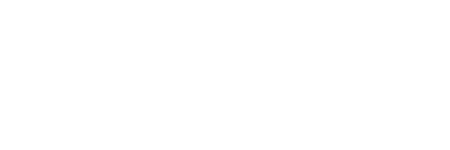

In [9]:
## Using MCS seed:
rdfmcs_mapper_withSeed =  openfe.setup.atom_mapping.RDFMCSMapper() 
rdfmcs_mapper_withSeed.common_core(mols[:2])

print(rdfmcs_mapper.mcs_seed)
q = Chem.MolFromSmarts(rdfmcs_mapper.mcs_seed)
mcs_smile = Chem.MolToSmiles(q)
print(mcs_smile)
q


CPU times: user 3.2 ms, sys: 86 µs, total: 3.28 ms
Wall time: 2.83 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.7655172413793104


[18:31:22] The provided InitialSeed is not an MCS and will be ignored


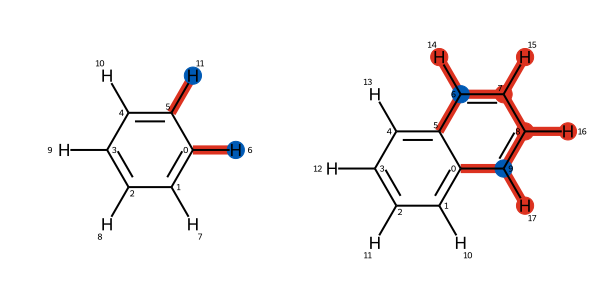

In [10]:
# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
%time rdfmcs_mapping_seeded = next(rdfmcs_mapper_withSeed.suggest_mappings(molA, molB))

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(rdfmcs_mapping_seeded)}")
print(f"Perses-Score is {perses_scorer(rdfmcs_mapping_seeded)}")

rdfmcs_mapping_seeded

# Use of Atom Mappers as iterables

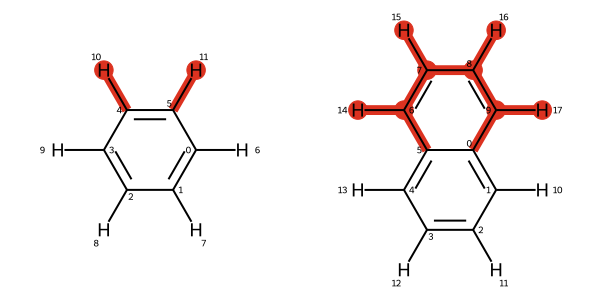

Lomap-Score is 0.6321205588285577
Perses-Score is 1.7645282094420575e-06


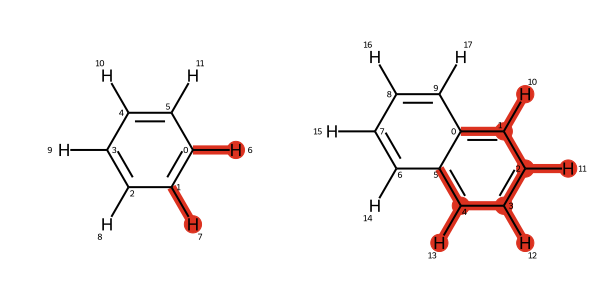

Lomap-Score is 0.6321205588285577
Perses-Score is 0.9861582699192621


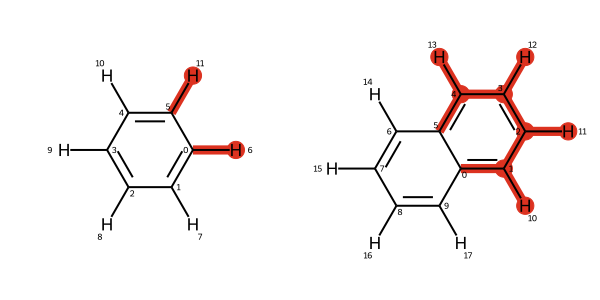

Lomap-Score is 0.6321205588285577
Perses-Score is 1.956300904516365


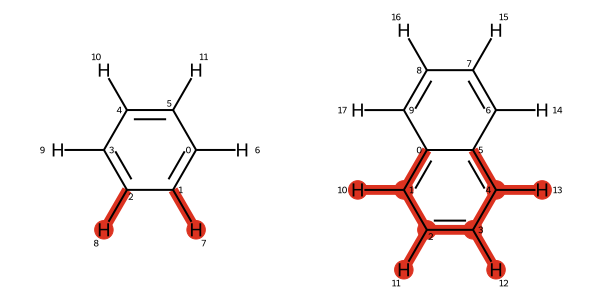

Lomap-Score is 0.6321205588285577
Perses-Score is 3.1644104775112727e-19


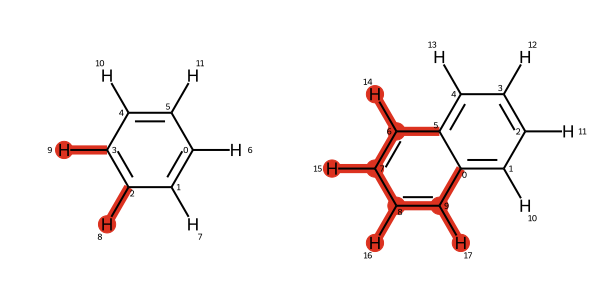

Lomap-Score is 0.6321205588285577
Perses-Score is 1.9608288134186105


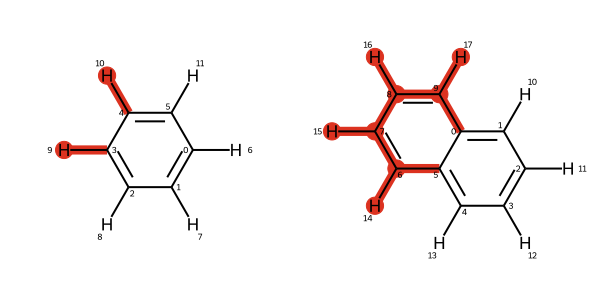

Lomap-Score is 0.6321205588285577
Perses-Score is 1.3841592022902562e-19


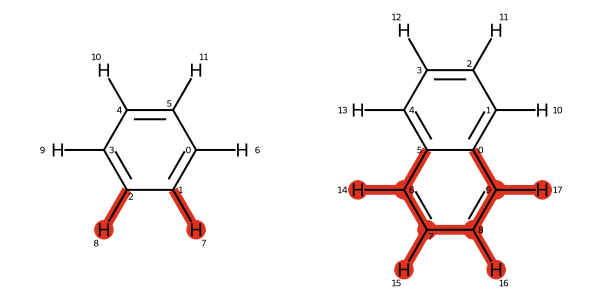

Lomap-Score is 0.6321205588285577
Perses-Score is 1.1199571098756712e-06


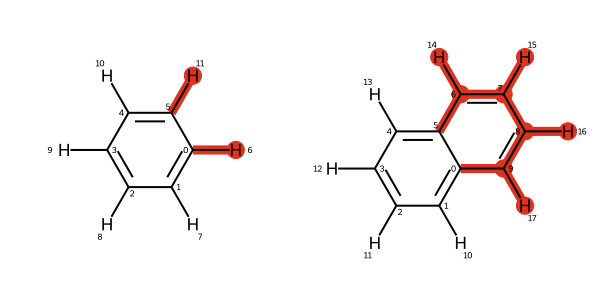

Lomap-Score is 0.6321205588285577
Perses-Score is 5.866545330575211


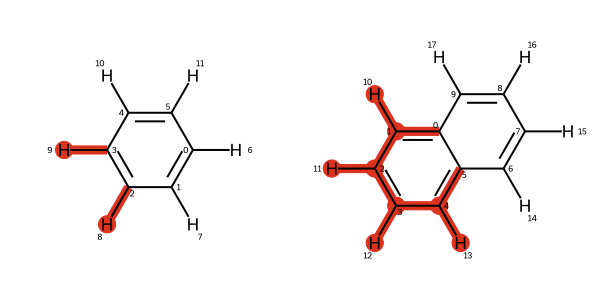

Lomap-Score is 0.6321205588285577
Perses-Score is 5.881546106847091e-26


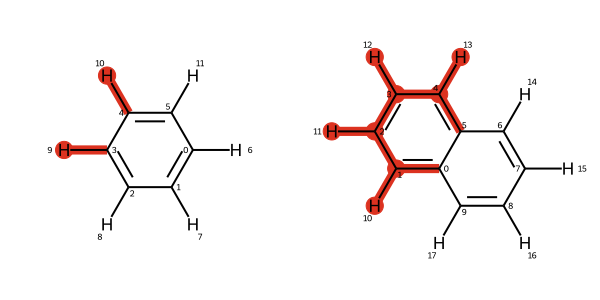

Lomap-Score is 0.6321205588285577
Perses-Score is 1.5832490460695691e-06


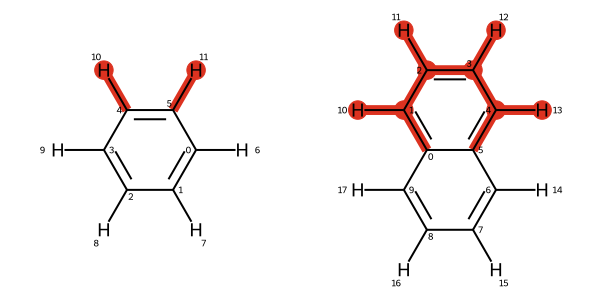

Lomap-Score is 0.6321205588285577
Perses-Score is 0.9701426345971029


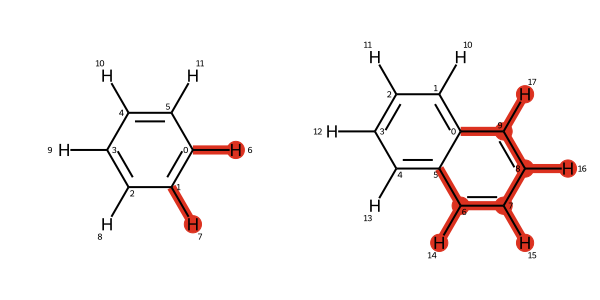

Lomap-Score is 0.6321205588285577
Perses-Score is 1.9512111387874098


In [11]:
#Get multiple mappings
from IPython.display import display
from openfe.setup.atom_mapping.perses_mapper import PersesAtomMapper

perses_mapper = PersesAtomMapper(allow_ring_breaking=True)
perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score

for x in perses_mapper.suggest_mappings(mols[0], mols[3]):
    display(x)

    print(f"Lomap-Score is {lomap_scorer(x)}")
    print(f"Perses-Score is {perses_scorer(x, use_positions=True, normalize=False)}")

In [12]:
#Let s align a ton of molecueles :) 
# LomapAtomMapper wraps the lomap.mcs.MCS object
lomap_mapper = openfe.setup.LomapAtomMapper()

for ind, molA in enumerate(mols[:-1]):
    for molB in mols[ind+1:]:        
        # mappers can return an *iterable* of mappings,
        # for our case just grab the first with `next()`
        %time lomap_mapping = next(lomap_mapper.suggest_mappings(molA, molB))

        #perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
        lomap_scorer = openfe.setup.lomap_scorers.default_lomap_score
        print(f"Lomap-Score is {lomap_scorer(lomap_mapping)}")
        #print(f"Perses-Score is {perses_scorer(lomap_mapping)}")

        #display(lomap_mapping) # nice but loooots of output, try it :)

CPU times: user 36.9 ms, sys: 1.09 ms, total: 38 ms
Wall time: 37.1 ms
Lomap-Score is 0.09516258196404048
CPU times: user 36.3 ms, sys: 0 ns, total: 36.3 ms
Wall time: 36.1 ms
Lomap-Score is 0.09516258196404048
CPU times: user 63.9 ms, sys: 139 µs, total: 64.1 ms
Wall time: 63.7 ms
Lomap-Score is 0.3296799539643607
CPU times: user 36.6 ms, sys: 72 µs, total: 36.7 ms
Wall time: 36.6 ms
Lomap-Score is 0.2591817793182821
CPU times: user 36.3 ms, sys: 69 µs, total: 36.4 ms
Wall time: 36.3 ms
Lomap-Score is 0.2591817793182821
CPU times: user 36.8 ms, sys: 646 µs, total: 37.4 ms
Wall time: 37.2 ms
Lomap-Score is 0.3296799539643607
CPU times: user 40.6 ms, sys: 253 µs, total: 40.8 ms
Wall time: 40.8 ms
Lomap-Score is 0.3296799539643607
CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 13.3 ms
Lomap-Score is 0.1392920235749422
CPU times: user 35.8 ms, sys: 0 ns, total: 35.8 ms
Wall time: 35.7 ms
Lomap-Score is 0.18126924692201818
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall 

[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
CPU times: user 1.96 ms, sys: 16 µs, total: 1.98 ms
Wall time: 1.71 ms
Lomap-Score is 0.09516258196404048
Perses-Score is 0.67704280155642


[18:31:27] The provided InitialSeed is not an MCS and will be ignored


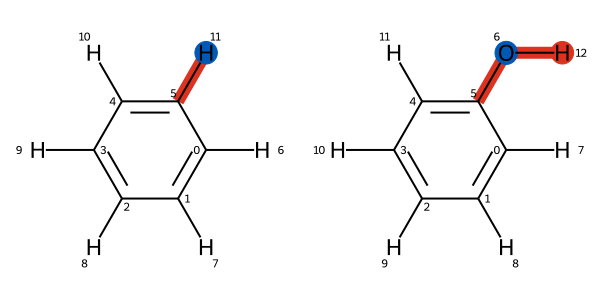

CPU times: user 1.75 ms, sys: 0 ns, total: 1.75 ms
Wall time: 1.43 ms
Lomap-Score is 0.09516258196404048
Perses-Score is 0.67704280155642


[18:31:27] The provided InitialSeed is not an MCS and will be ignored


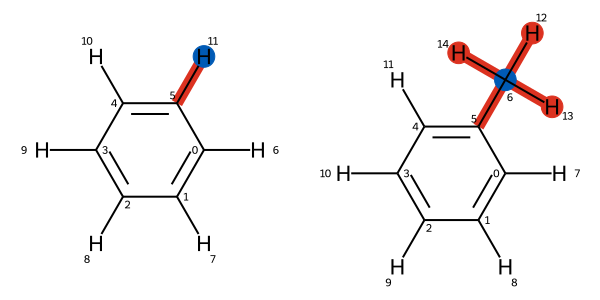

CPU times: user 2.18 ms, sys: 48 µs, total: 2.22 ms
Wall time: 1.74 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.67704280155642


[18:31:27] The provided InitialSeed is not an MCS and will be ignored


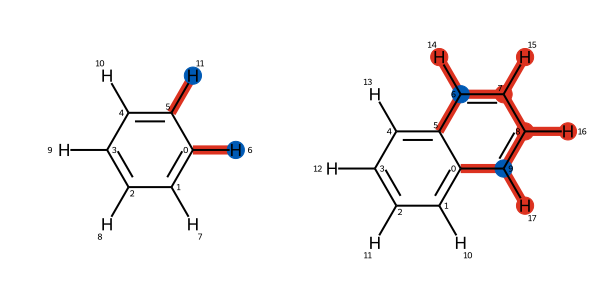

CPU times: user 1.71 ms, sys: 0 ns, total: 1.71 ms
Wall time: 1.39 ms
Lomap-Score is 0.2591817793182821
Perses-Score is 0.67704280155642


[18:31:27] The provided InitialSeed is not an MCS and will be ignored


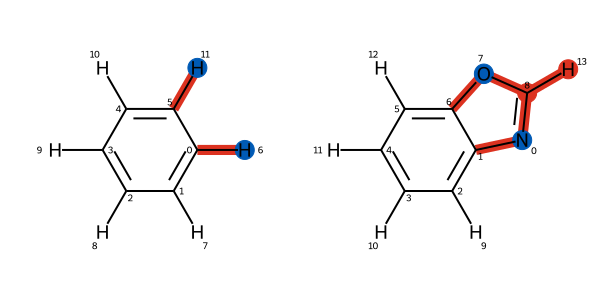

CPU times: user 1.94 ms, sys: 0 ns, total: 1.94 ms
Wall time: 1.56 ms
Lomap-Score is 0.2591817793182821
Perses-Score is 0.67704280155642


[18:31:27] The provided InitialSeed is not an MCS and will be ignored


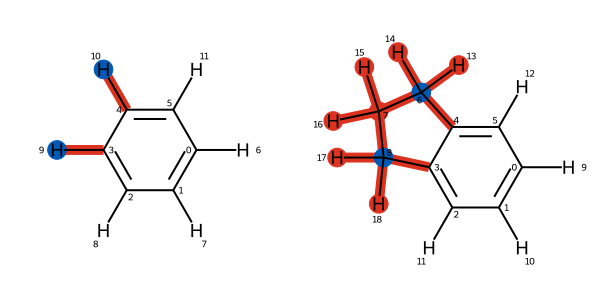

[18:31:27] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.04 ms, sys: 11 µs, total: 2.05 ms
Wall time: 1.71 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.67704280155642


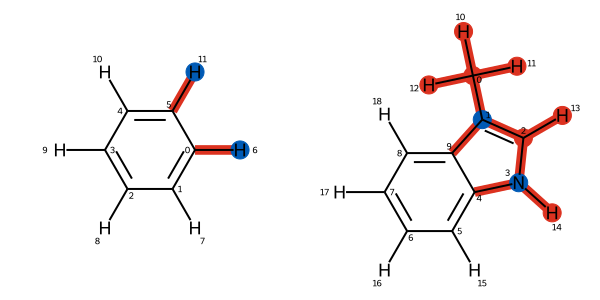

[18:31:27] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.58 ms, sys: 152 µs, total: 1.73 ms
Wall time: 1.38 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.67704280155642


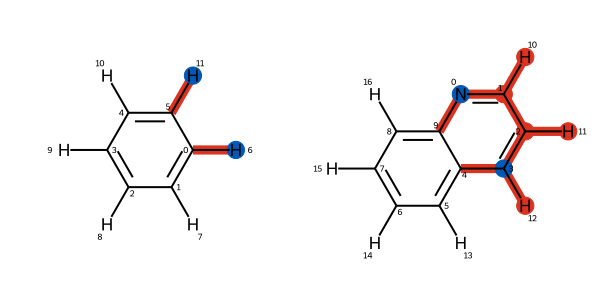

CPU times: user 1.81 ms, sys: 0 ns, total: 1.81 ms
Wall time: 1.49 ms
Lomap-Score is 0.1392920235749422
Perses-Score is 0.67704280155642


[18:31:27] The provided InitialSeed is not an MCS and will be ignored


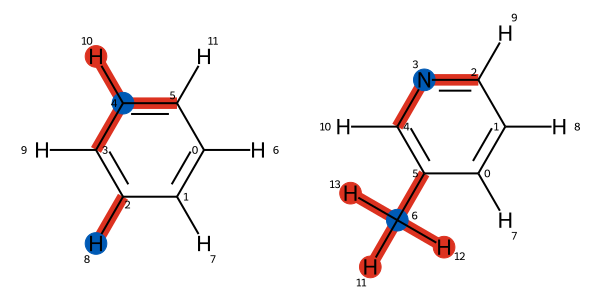

[18:31:27] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.72 ms, sys: 0 ns, total: 1.72 ms
Wall time: 1.38 ms
Lomap-Score is 0.18126924692201818
Perses-Score is 0.67704280155642


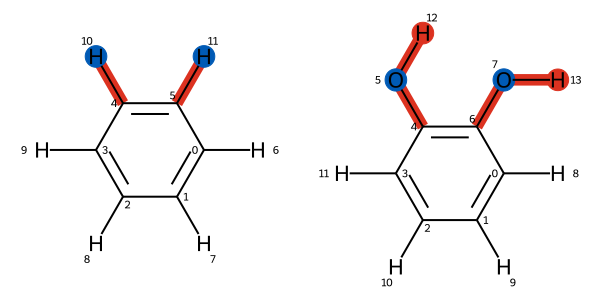

[18:31:27] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 775 µs, sys: 942 µs, total: 1.72 ms
Wall time: 1.39 ms
Lomap-Score is 0.2591817793182821
Perses-Score is 0.67704280155642


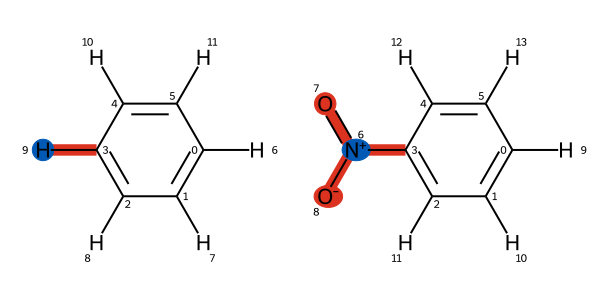

[18:31:27] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.49 ms, sys: 127 µs, total: 1.62 ms
Wall time: 1.37 ms
Lomap-Score is 0.5934303402594008
Perses-Score is 0.67704280155642


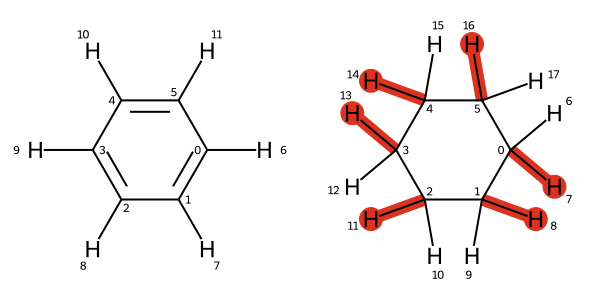

CPU times: user 1.66 ms, sys: 0 ns, total: 1.66 ms
Wall time: 1.4 ms
Lomap-Score is 0.048770575499285984
Perses-Score is 0.67704280155642


[18:31:27] The provided InitialSeed is not an MCS and will be ignored


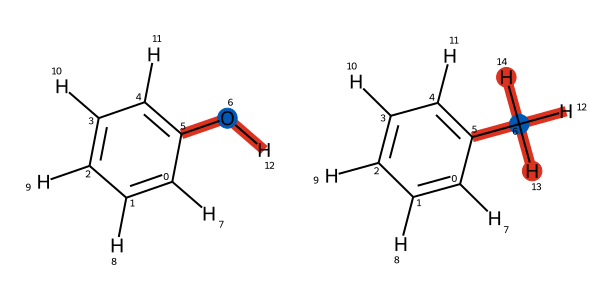

CPU times: user 1.57 ms, sys: 145 µs, total: 1.71 ms
Wall time: 1.42 ms
Lomap-Score is 0.6671289163019205
Perses-Score is 0.67704280155642


[18:31:27] The provided InitialSeed is not an MCS and will be ignored


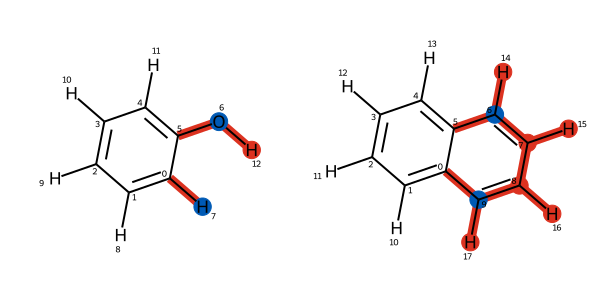

CPU times: user 1.53 ms, sys: 134 µs, total: 1.66 ms
Wall time: 1.38 ms
Lomap-Score is 0.5506710358827784


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


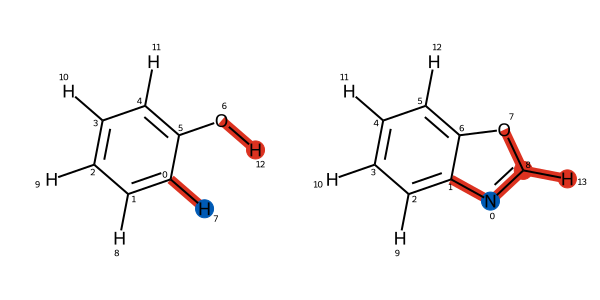

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.96 ms, sys: 736 µs, total: 2.69 ms
Wall time: 2.21 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.67704280155642


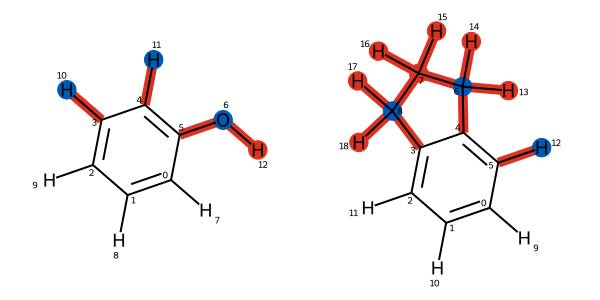

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.36 ms, sys: 90 µs, total: 2.45 ms
Wall time: 1.93 ms
Lomap-Score is 0.6671289163019205
Perses-Score is 0.67704280155642


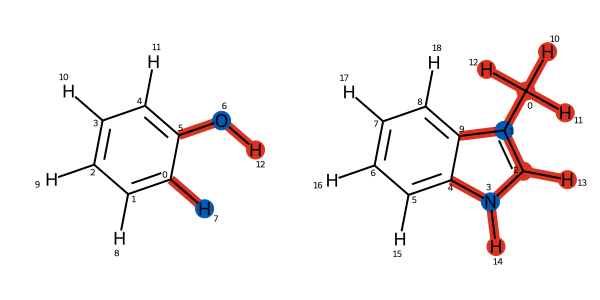

CPU times: user 2.02 ms, sys: 6 µs, total: 2.03 ms
Wall time: 1.7 ms
Lomap-Score is 0.6671289163019205


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


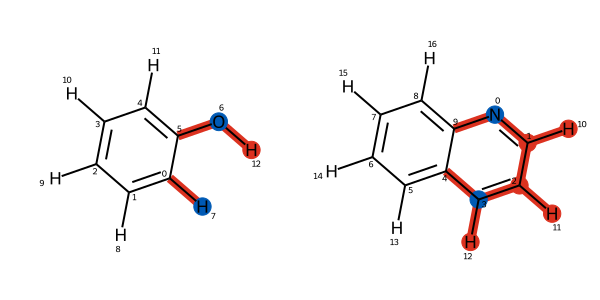

CPU times: user 1.89 ms, sys: 0 ns, total: 1.89 ms
Wall time: 1.65 ms
Lomap-Score is 0.22119921692859512


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


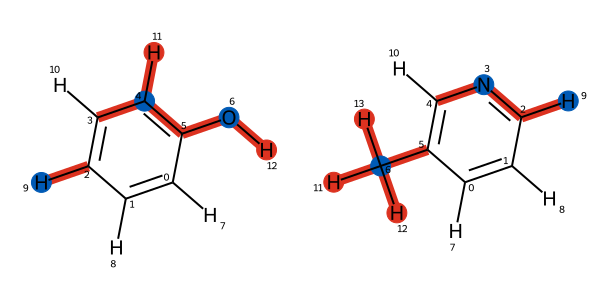

CPU times: user 1.26 ms, sys: 834 µs, total: 2.1 ms
Wall time: 1.71 ms
Lomap-Score is 0.09516258196404048
Perses-Score is 0.67704280155642


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


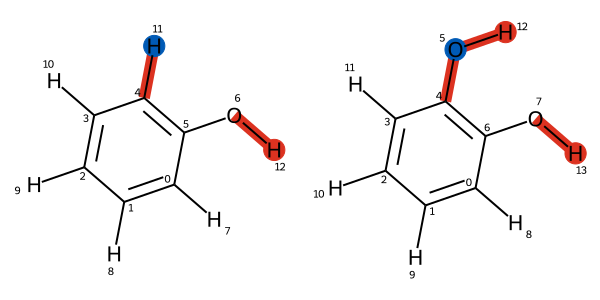

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 1.64 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.67704280155642


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


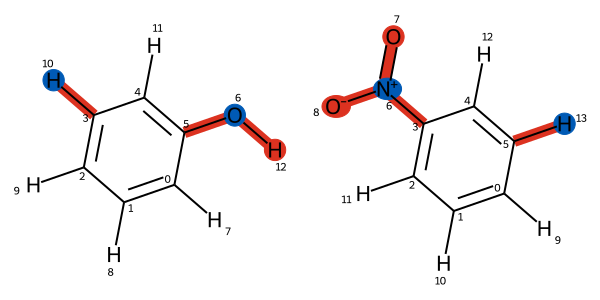

CPU times: user 2.37 ms, sys: 0 ns, total: 2.37 ms
Wall time: 1.94 ms
Lomap-Score is 0.6321205588285577
Perses-Score is 0.67704280155642


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


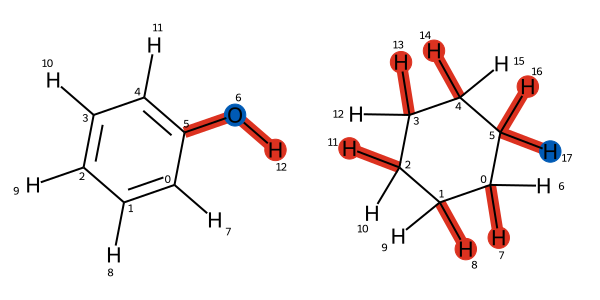

CPU times: user 2.06 ms, sys: 17 µs, total: 2.08 ms
Wall time: 1.8 ms
Lomap-Score is 0.36237184837822667
Perses-Score is 0.67704280155642


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


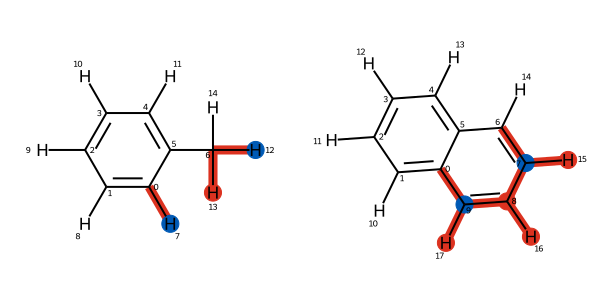

CPU times: user 2 ms, sys: 1e+03 ns, total: 2 ms
Wall time: 1.71 ms
Lomap-Score is 0.5725850680512734
Perses-Score is 0.67704280155642


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


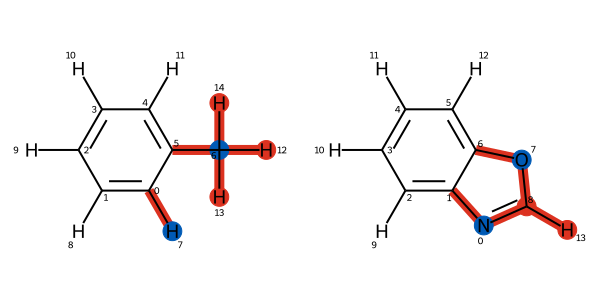

CPU times: user 2.03 ms, sys: 9 µs, total: 2.04 ms
Wall time: 1.68 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.67704280155642


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


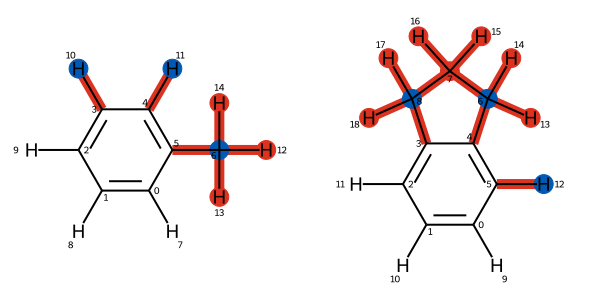

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.98 ms, sys: 0 ns, total: 1.98 ms
Wall time: 1.75 ms
Lomap-Score is 0.6500622508888447
Perses-Score is 0.67704280155642


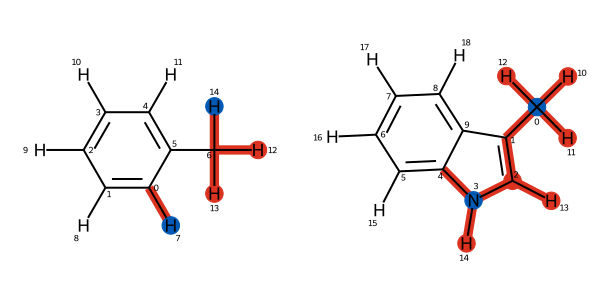

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 827 µs, sys: 1.2 ms, total: 2.02 ms
Wall time: 1.69 ms
Lomap-Score is 0.3934693402873666
Perses-Score is 0.67704280155642


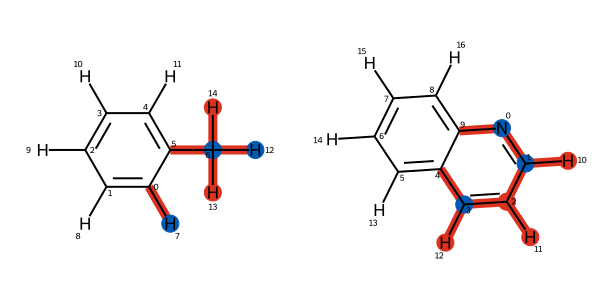

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.58 ms, sys: 72 µs, total: 1.66 ms
Wall time: 1.66 ms
Lomap-Score is 0.22119921692859512
Perses-Score is 0.67704280155642


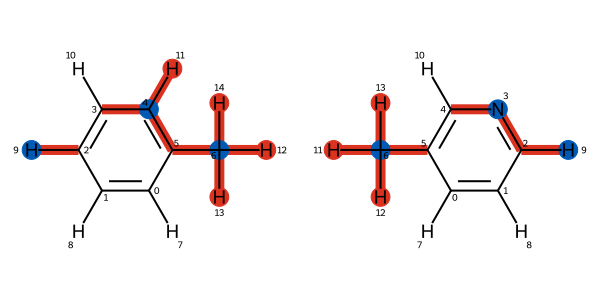

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 2.35 ms
Lomap-Score is 0.1392920235749422
Perses-Score is 0.67704280155642


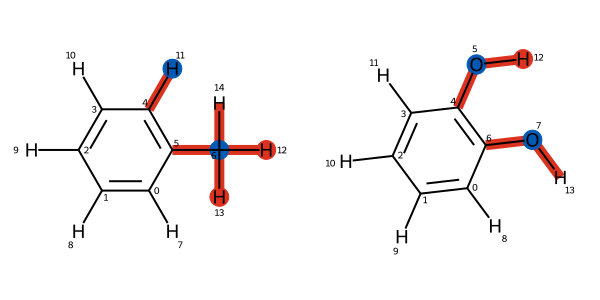

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 1.71 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.67704280155642


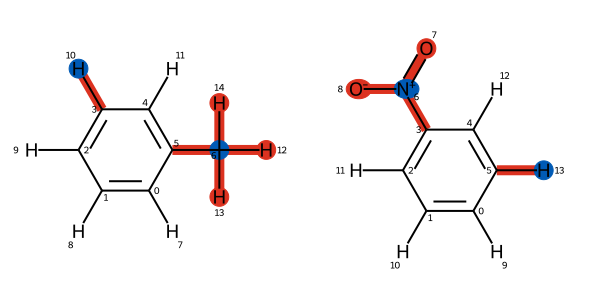

CPU times: user 2.12 ms, sys: 29 µs, total: 2.15 ms
Wall time: 1.84 ms
Lomap-Score is 0.6321205588285577
Perses-Score is 0.67704280155642


[18:31:28] The provided InitialSeed is not an MCS and will be ignored


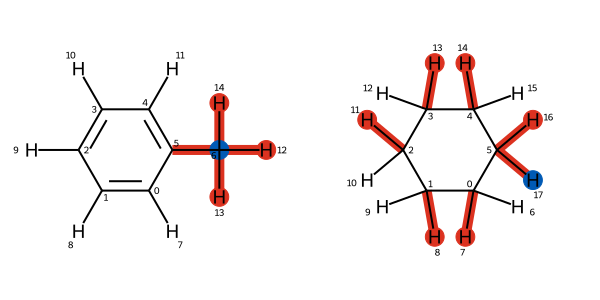

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.92 ms, sys: 17 µs, total: 2.93 ms
Wall time: 2.62 ms
Lomap-Score is 0.6132589765454989
Perses-Score is 0.67704280155642


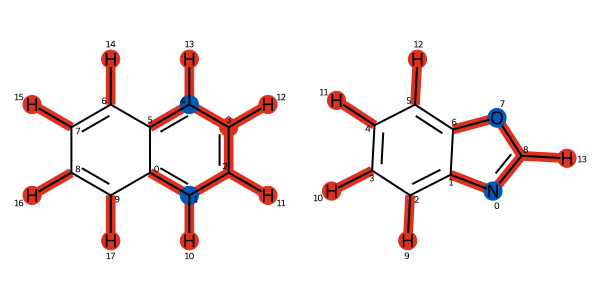

[18:31:28] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.12 ms, sys: 29 µs, total: 2.15 ms
Wall time: 1.86 ms
Lomap-Score is 0.5034146962085906
Perses-Score is 0.67704280155642


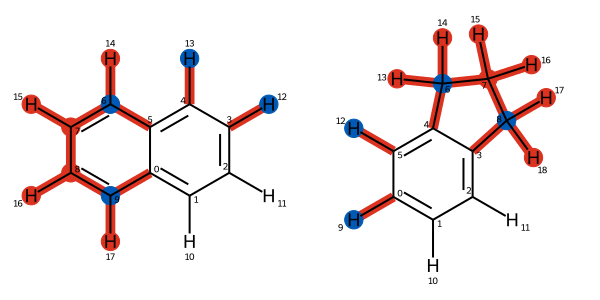

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.88 ms, sys: 741 µs, total: 2.62 ms
Wall time: 2.33 ms
Lomap-Score is 0.3296799539643607
Perses-Score is 0.67704280155642


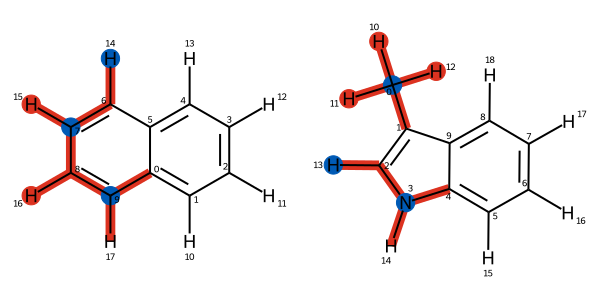

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 3.27 ms, sys: 62 µs, total: 3.33 ms
Wall time: 3.08 ms
Lomap-Score is 0.048770575499285984
Perses-Score is 0.67704280155642


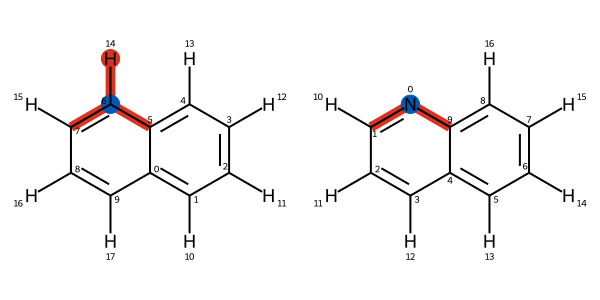

CPU times: user 2.22 ms, sys: 0 ns, total: 2.22 ms
Wall time: 1.97 ms
Lomap-Score is 0.6833632306209468


[18:31:29] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


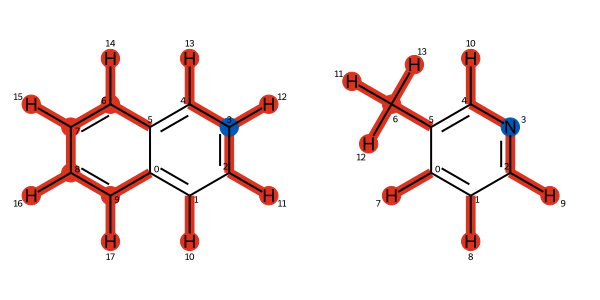

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.73 ms, sys: 727 µs, total: 2.46 ms
Wall time: 2.12 ms
Lomap-Score is 0.4511883639059735
Perses-Score is 0.67704280155642


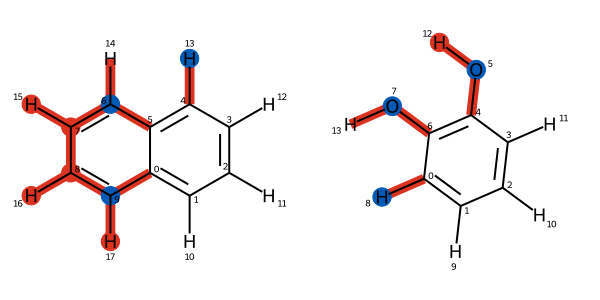

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.38 ms, sys: 86 µs, total: 2.46 ms
Wall time: 2.11 ms
Lomap-Score is 0.5034146962085906
Perses-Score is 0.67704280155642


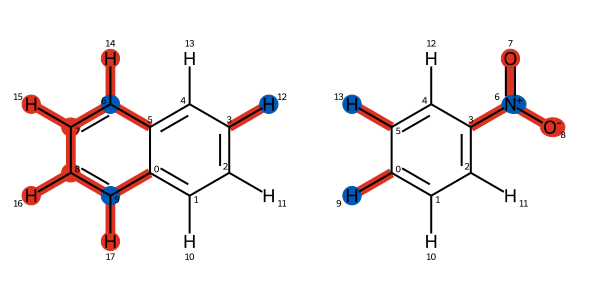

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.55 ms, sys: 900 µs, total: 2.45 ms
Wall time: 2.04 ms
Lomap-Score is 0.7274682069659872
Perses-Score is 0.67704280155642


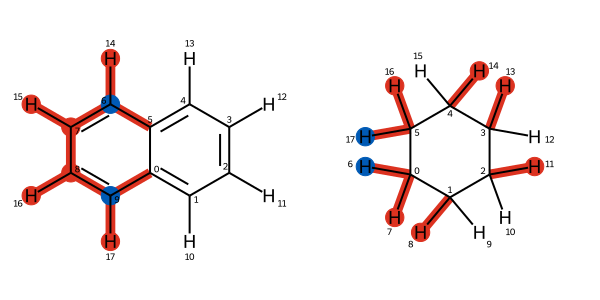

CPU times: user 2.31 ms, sys: 70 µs, total: 2.38 ms
Wall time: 1.96 ms
Lomap-Score is 0.4511883639059736


[18:31:29] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


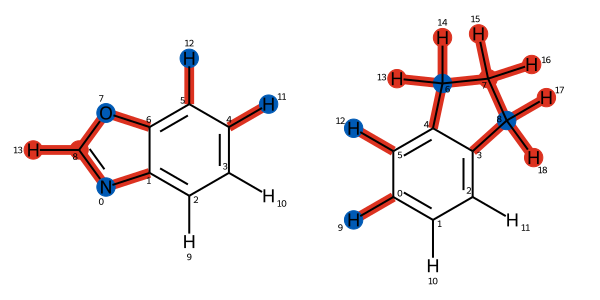

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.72 ms, sys: 161 µs, total: 2.88 ms
Wall time: 2.59 ms
Lomap-Score is 0.2591817793182821
Perses-Score is 0.67704280155642


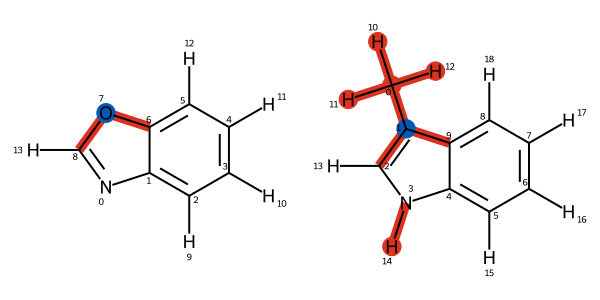

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 4.11 ms, sys: 24 µs, total: 4.13 ms
Wall time: 3.91 ms
Lomap-Score is 0.6132589765454989
Perses-Score is 0.67704280155642


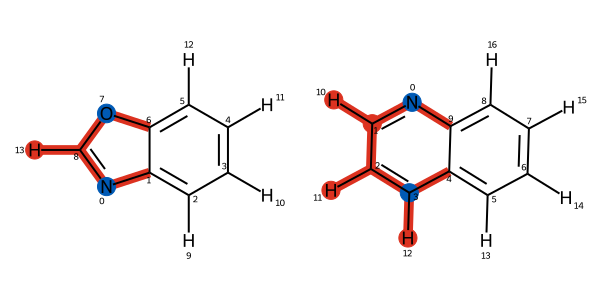

CPU times: user 2.21 ms, sys: 48 µs, total: 2.26 ms
Wall time: 1.9 ms
Lomap-Score is 0.6500622508888447


[18:31:29] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


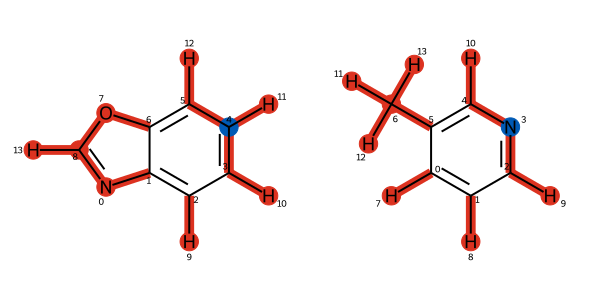

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 1.82 ms
Lomap-Score is 0.5934303402594009
Perses-Score is 0.67704280155642


[18:31:29] The provided InitialSeed is not an MCS and will be ignored


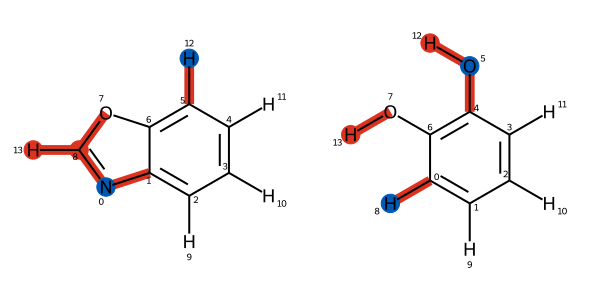

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 1.65 ms
Lomap-Score is 0.4511883639059736
Perses-Score is 0.67704280155642


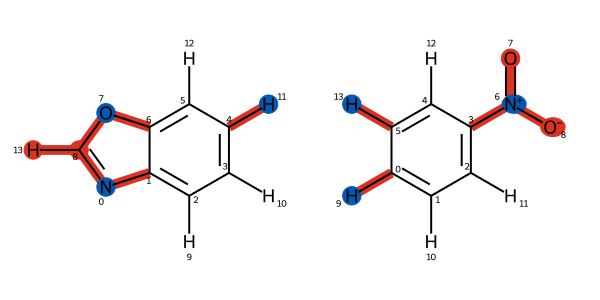

CPU times: user 2.08 ms, sys: 2 µs, total: 2.08 ms
Wall time: 1.8 ms
Lomap-Score is 0.6988057880877978
Perses-Score is 0.67704280155642


[18:31:29] The provided InitialSeed is not an MCS and will be ignored


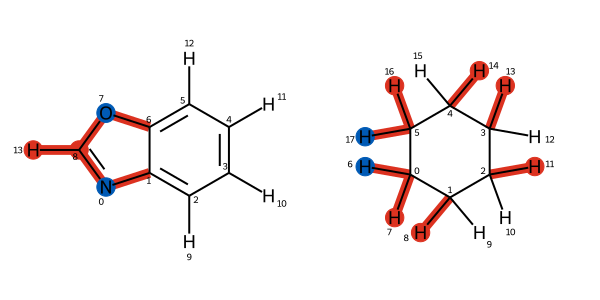

CPU times: user 2.16 ms, sys: 34 µs, total: 2.19 ms
Wall time: 1.75 ms
Lomap-Score is 0.5034146962085906


[18:31:29] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


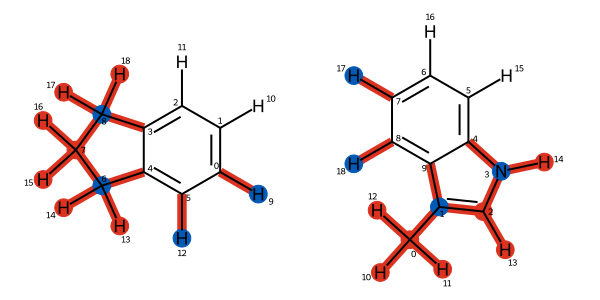

CPU times: user 1.6 ms, sys: 699 µs, total: 2.3 ms
Wall time: 1.98 ms
Lomap-Score is 0.5034146962085906
Perses-Score is 0.67704280155642


[18:31:29] The provided InitialSeed is not an MCS and will be ignored


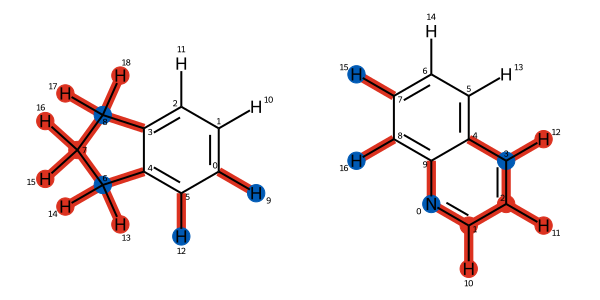

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.27 ms, sys: 59 µs, total: 2.33 ms
Wall time: 1.87 ms
Lomap-Score is 0.6500622508888447
Perses-Score is 0.67704280155642


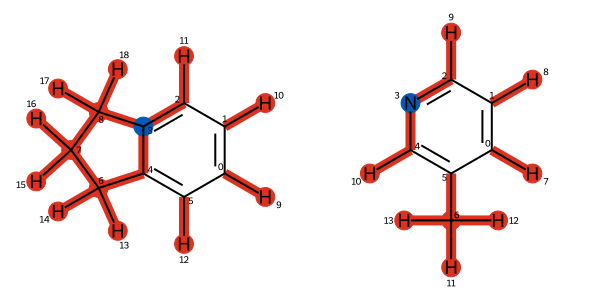

[18:31:29] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.06 ms, sys: 78 µs, total: 2.14 ms
Wall time: 1.82 ms
Lomap-Score is 0.6132589765454988
Perses-Score is 0.67704280155642


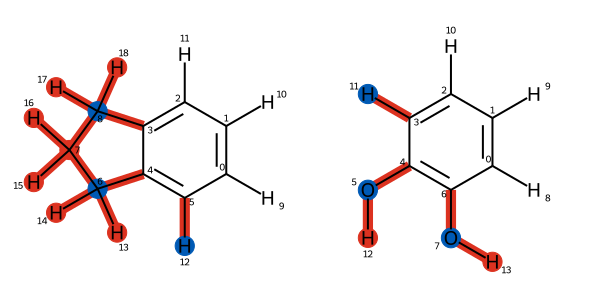

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.09 ms, sys: 0 ns, total: 2.09 ms
Wall time: 2.13 ms
Lomap-Score is 0.6988057880877978
Perses-Score is 0.67704280155642


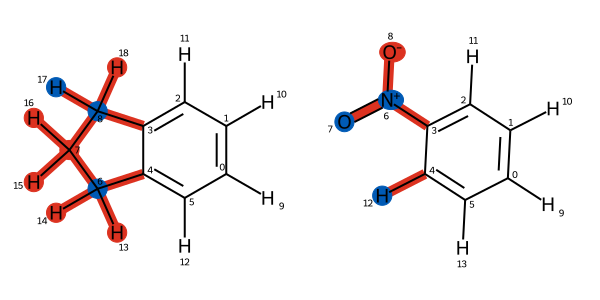

CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 1.92 ms


[18:31:30] The provided InitialSeed is not an MCS and will be ignored


Lomap-Score is 0.6988057880877978
Perses-Score is 0.67704280155642


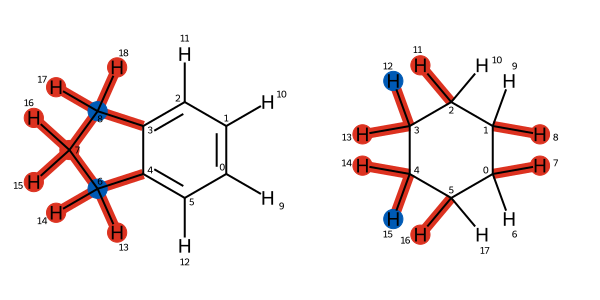

CPU times: user 2.44 ms, sys: 93 µs, total: 2.53 ms
Wall time: 2.22 ms
Lomap-Score is 0.6500622508888447
Perses-Score is 0.67704280155642


[18:31:30] The provided InitialSeed is not an MCS and will be ignored


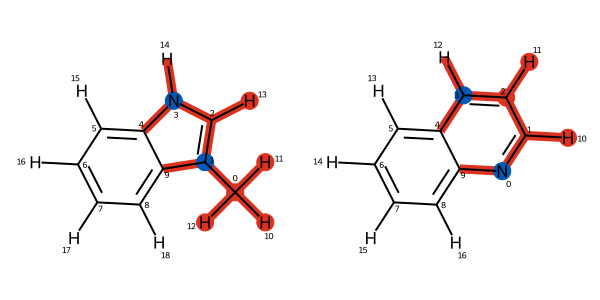

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.37 ms, sys: 0 ns, total: 2.37 ms
Wall time: 2.12 ms
Lomap-Score is 0.6833632306209468
Perses-Score is 0.67704280155642


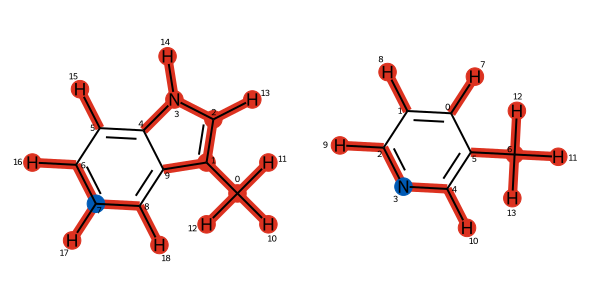

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.09 ms, sys: 53 µs, total: 2.14 ms
Wall time: 1.83 ms
Lomap-Score is 0.4511883639059735
Perses-Score is 0.67704280155642


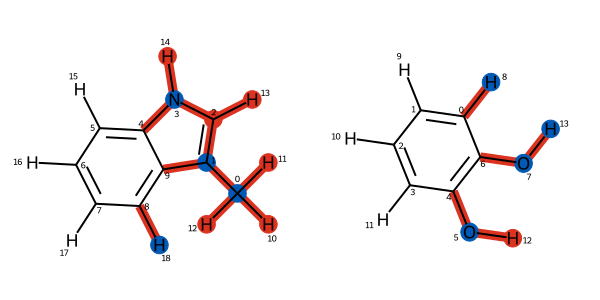

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.99 ms, sys: 0 ns, total: 1.99 ms
Wall time: 1.69 ms
Lomap-Score is 0.5034146962085906
Perses-Score is 0.67704280155642


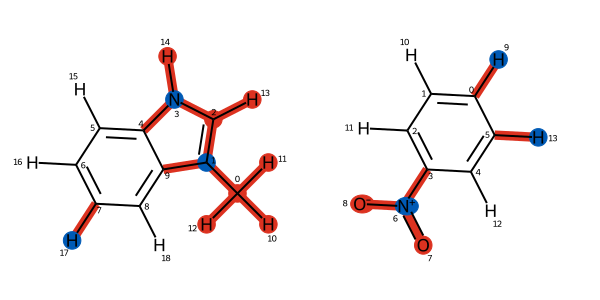

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 1.62 ms
Lomap-Score is 0.7274682069659872
Perses-Score is 0.67704280155642


[18:31:30] The provided InitialSeed is not an MCS and will be ignored


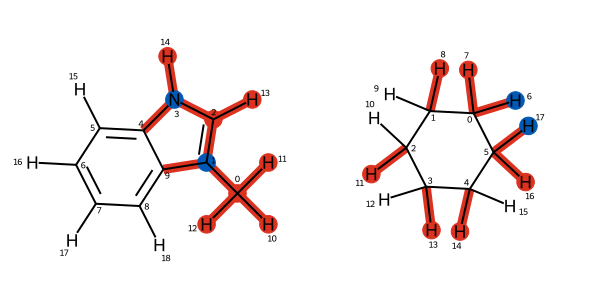

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.83 ms, sys: 77 µs, total: 1.91 ms
Wall time: 1.62 ms
Lomap-Score is 0.6671289163019205
Perses-Score is 0.67704280155642


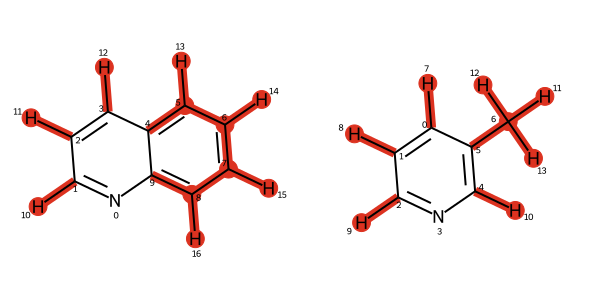

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.15 ms, sys: 32 µs, total: 2.18 ms
Wall time: 1.9 ms
Lomap-Score is 0.6988057880877978
Perses-Score is 0.67704280155642


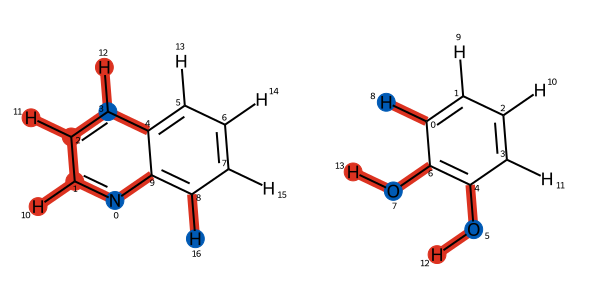

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 1.95 ms
Lomap-Score is 0.5034146962085906
Perses-Score is 0.67704280155642


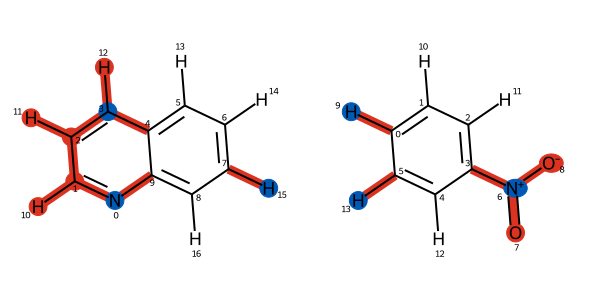

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 2.02 ms
Lomap-Score is 0.7274682069659872
Perses-Score is 0.67704280155642


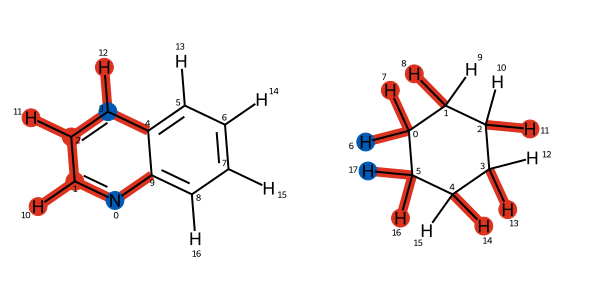

CPU times: user 1.99 ms, sys: 0 ns, total: 1.99 ms
Wall time: 1.71 ms
Lomap-Score is 0.29531191028128656


[18:31:30] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


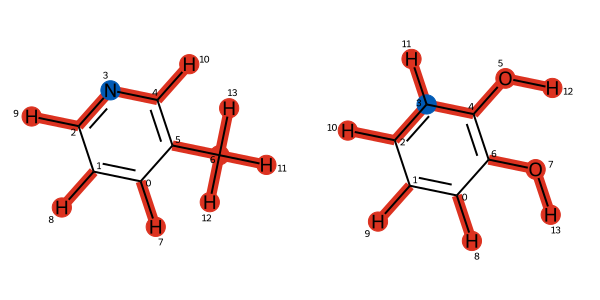

CPU times: user 1.93 ms, sys: 0 ns, total: 1.93 ms
Wall time: 1.64 ms
Lomap-Score is 0.36237184837822667
Perses-Score is 0.67704280155642


[18:31:30] The provided InitialSeed is not an MCS and will be ignored


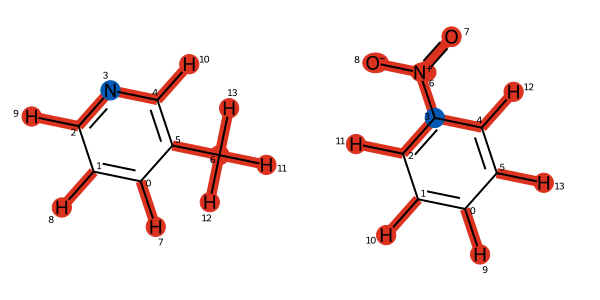

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 1.69 ms
Lomap-Score is 0.6500622508888445


[18:31:30] The provided InitialSeed is not an MCS and will be ignored


Perses-Score is 0.67704280155642


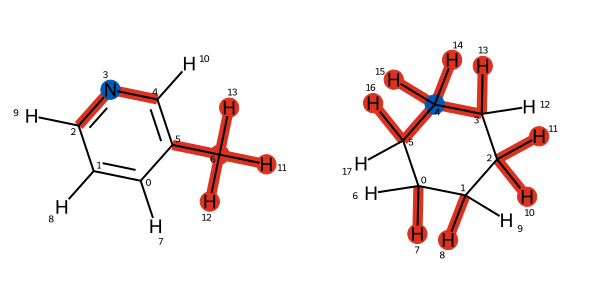

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 1.57 ms
Lomap-Score is 0.3934693402873666
Perses-Score is 0.67704280155642


[18:31:30] The provided InitialSeed is not an MCS and will be ignored


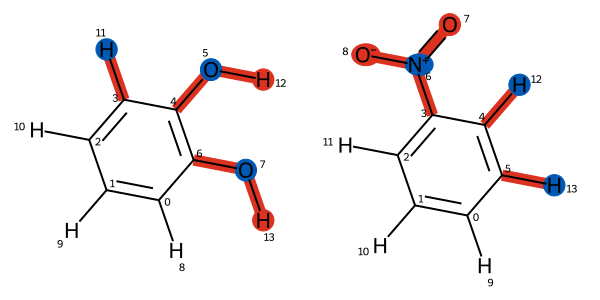

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.62 ms, sys: 123 µs, total: 1.74 ms
Wall time: 1.54 ms
Lomap-Score is 0.6671289163019204
Perses-Score is 0.67704280155642


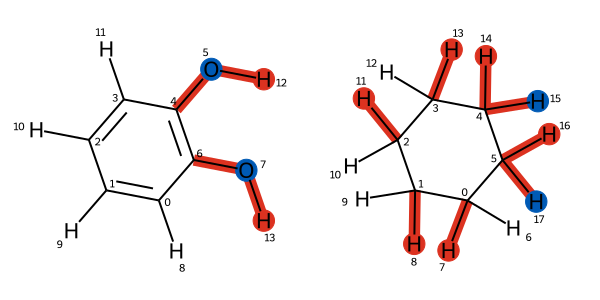

[18:31:30] The provided InitialSeed is not an MCS and will be ignored


CPU times: user 1.63 ms, sys: 125 µs, total: 1.76 ms
Wall time: 1.46 ms
Lomap-Score is 0.6988057880877978
Perses-Score is 0.67704280155642


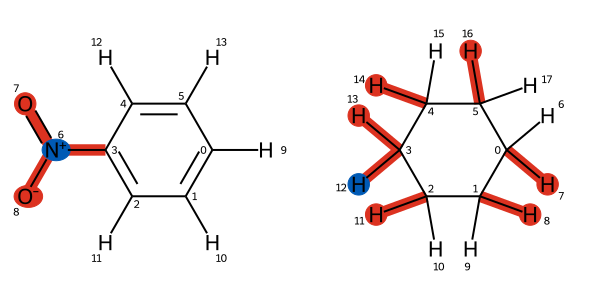

In [13]:
#Let s align a ton of molecueles :) 
# RDFMCSMapper wraps the lomap.mcs.MCS object
rdfmcs_mapper = openfe.setup.RDFMCSMapper()
perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score

rdfmcs_mapper.common_core(mols)
print(rdfmcs_mapper.mcs_seed)

for ind, molA in enumerate(mols[:-1]):
    for molB in mols[ind+1:]:        
        # mappers can return an *iterable* of mappings,
        # for our case just grab the first with `next()`
        %time rdfmcs_mapping = next(rdfmcs_mapper.suggest_mappings(molA, molB))

        print(f"Lomap-Score is {lomap_scorer(rdfmcs_mapping)}")
        print(f"Perses-Score is {perses_scorer(lomap_mapping)}")

        display(rdfmcs_mapping) # nice but loooots of output, try it :)

## Timings:
### RDFMCS-Mapper Timings:

In [14]:
rdfmcs_mapper_withSeed =  openfe.setup.RDFMCSMapper() 
rdfmcs_mapper_noSeed =  openfe.setup.RDFMCSMapper()

In [15]:
%%timeit

mappings = []
molA = mols[0]
scores = []
for ind, molA in enumerate(mols[:-1]):
    for molB in mols[ind+1:]:
        rdfmcs_mapping = next(rdfmcs_mapper_noSeed.suggest_mappings(molA, molB))
        mappings.append(rdfmcs_mapping)
        scores.append(lomap_scorer(rdfmcs_mapping))


197 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
rdfmcs_mapper_withSeed.common_core(mols)

mappings = []
molA = mols[0]
scores = []
for ind, molA in enumerate(mols[:-1]):
    for molB in mols[ind+1:]:
        rdfmcs_mapping = next(rdfmcs_mapper_withSeed.suggest_mappings(molA, molB))
        mappings.append(rdfmcs_mapping)
        scores.append(lomap_scorer(rdfmcs_mapping))

[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]


[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:14] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provi

[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]


[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provi

[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]


[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provi

[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]


[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provided InitialSeed is not an MCS and will be ignored
[18:32:15] The provi

[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]


[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provi

[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]


[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provi

[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
[#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]
DOAAA:  [#6]1:,-[#6](:,-[#6](:,-[#6](:,-[#6]:,-[#6]:,-1)-[#1])-[#1])-[#1]


[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provi

232 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provided InitialSeed is not an MCS and will be ignored
[18:32:16] The provi

### LOMAP Mapper

In [17]:
from openfe.setup.atom_mapping.lomap_mapper import LomapAtomMapper
lomap_mapper = LomapAtomMapper()


In [18]:
%%timeit

mappings = []
molA = mols[0]
scores = []
for ind, molA in enumerate(mols[:-1]):
    for molB in mols[ind+1:]:
        lomap_mapping = next(lomap_mapper.suggest_mappings(molA, molB))
        mappings.append(lomap_mapping)
        scores.append(lomap_scorer(lomap_mapping))


2.59 s ± 58.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Perses Mapper

In [19]:
from openfe.setup.atom_mapping.perses_mapper import PersesAtomMapper
perses_mapper = PersesAtomMapper()


In [20]:
%%timeit

mappings = []
molA = mols[0]
scores = []
for ind, molA in enumerate(mols[:-1]):
    for molB in mols[ind+1:]:
        perses_mapping = next(perses_mapper.suggest_mappings(molA, molB))
        mappings.append(perses_mapping)
        scores.append(lomap_scorer(perses_mapping))


TypeError: 'NoneType' object is not iterable